In [92]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [93]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))

In [140]:
PREFIX = "main/ycsb-jitter-overshoot10"

index_sdf = get_index(PREFIX).withColumn("jitter", F.regexp_extract("prefix", r"jitter(\d+)", 1).cast('int')).cache()
index_df = index_sdf\
    .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
    .toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32",
    })

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
0,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter0,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0
1,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter10,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,10
2,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter15,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,15
3,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter20,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,20
4,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter25,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,25
5,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter30,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,30
6,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter35,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,35
7,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter40,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,40
8,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter5,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,5
9,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter0,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0


# Throughput

In [141]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res

    
def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_sdf.where(col("clients") == 3000)).sort_values("jitter"),
    ignore_cache=IGNORE_CACHE,
)

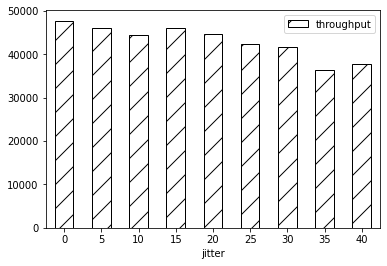

In [142]:
throughput_df.plot.bar(x="jitter", y="throughput", rot=0, fill=False, hatch='/')
plt.savefig("output/jitter-thrp.pdf")

# Deadlocks

<AxesSubplot:xlabel='jitter'>

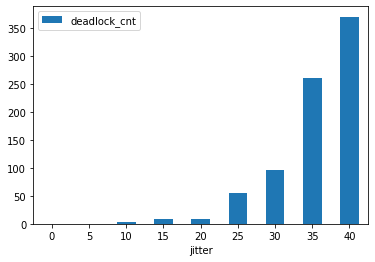

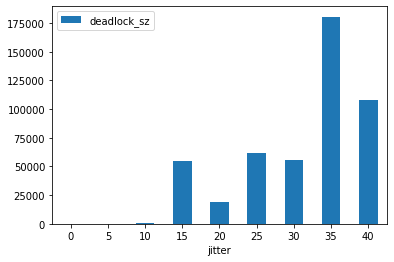

In [143]:
deadlocks_df = throughput_df[["prefix", "jitter"]].copy()
deadlocks_df["deadlock_cnt"] = 0
deadlocks_df["deadlock_sz"] = 0

for i, row in deadlocks_df.iterrows():
    sdf = deadlocks_csv(spark, row.prefix).where(col("replica") == 0)
    deadlocks_df.at[i, "deadlock_cnt"] = sdf.count()
    deadlocks_df.at[i, "deadlock_sz"] = sdf.agg({"vertices": "sum"}).collect()[0][0]

deadlocks_df.plot.bar(x="jitter", y="deadlock_cnt", rot=0)
deadlocks_df.plot.bar(x="jitter", y="deadlock_sz", rot=0)

# Latency

In [144]:
prefixes = list(
    map(
        lambda r : r["prefix"],
        index_sdf.select("prefix").where(col("clients") == 200).collect()
    )
)
latency_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_sdf = latency_sdf.groupBy("prefix").agg(*percentile_cols).cache()

In [145]:
IGNORE_CACHE = False

latency_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency_sdf.toPandas().merge(index_df, on="prefix").sort_values("jitter"),
    ignore_cache=IGNORE_CACHE,
)
latency_df

,prefix,p50,p90,p95,p99,version,config_name,duration,txns,clients,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
4,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter0,87.774976,130.182656,153.500928,230.734848,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,0
7,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter5,88.073984,126.879232,146.133504,229.821696,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,5
0,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter10,89.010176,126.363904,145.292544,228.999424,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,10
8,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter15,90.246400,128.950272,148.333312,229.953024,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,15
2,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter20,91.190528,130.227456,151.199488,232.713216,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,20
6,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter25,93.165312,132.668928,153.204480,234.616064,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,25
3,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter30,95.075840,134.213120,155.036672,237.698816,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,30
5,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter35,96.185856,138.981632,170.345728,283.466496,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,35
1,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter40,97.633536,144.631296,182.654464,259.259648,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,40


# Plot

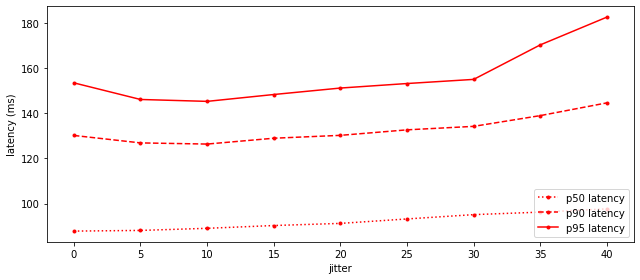

In [146]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))

# throughput_df.plot.bar(ax=ax, x="jitter", y="throughput", rot=0, fill=False, hatch='/')
# ax.set_ylabel("throughput (txn/s)")
# ax.set_xlabel("jitter")
# ax.legend(loc="lower left")
ax2 = ax

latency_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_df.plot(ax=ax2, x="jitter", y="p90", label='p90 latency', linestyle='dashed', marker='.', color="red")
latency_df.plot(ax=ax2, x="jitter", y="p95", label='p95 latency', marker='.', color="red")
# latency_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency', marker='.', color="red")
ax2.set_ylabel("latency (ms)")

ax2.legend(loc="lower right")
 
plt.tight_layout()
plt.savefig("output/jitter.pdf")
